In [16]:
!pip install python-Levenshtein

In [17]:
import numpy as np
import pandas as pd
from pandas.io.parsers import StringIO
from io import StringIO

import Levenshtein as Leven

from datetime import date
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import seaborn as sns

from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [20]:
#подгружаем чистые данные
data = pd.read_csv("cleaned_data.csv", sep=',')

In [21]:
#Оформляем
data = data.drop(columns=['issuer_eng', 'num', 'Unnamed: 0', 'index'])
data['issuer_eng'] = data['new']
data = data.drop(columns=['new'])

In [22]:
data.head()

,dept_code,cluster,issue_date,issuer_eng
0,20003,0,2001-11-05,OUFMS
1,20003,0,2019-05-14,OUFMS
2,20003,0,2001-11-05,MVD PO RB
3,20003,0,2019-05-14,MVD PO RB
4,20003,1,2002-03-22,MVD PO RESPUBLIKE BASHKORTOSTAN


In [23]:
# Заменяем дату на количество дней от минимальной в датасете
data['issue_date']= pd.to_datetime(data['issue_date'])
fromDate = min(data['issue_date'])
data['timedelta'] = (data['issue_date'] - fromDate).dt.days.astype(int)
print(data[['issue_date', 'timedelta']].head())
data.drop('issue_date', axis = 1, inplace = True)

  issue_date  timedelta
0 2001-11-05        305
1 2019-05-14       6704
2 2001-11-05        305
3 2019-05-14       6704
4 2002-03-22        442


In [24]:
#Делим на тестовую и обучающую
x_data = data[['dept_code', 'timedelta']]
y_data = data[['issuer_eng']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [25]:
#Смотрим на точность классификатора с рандомным количеством соседей
neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(x_train, y_train)
y_test['knn_predict'] = neigh.predict(x_test)
neigh.score(x_test, y_test['issuer_eng'])

0.9466698610445615

In [26]:
#Определеям оптимальное количество соседей
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(x_train, y_train)
knn_gscv.best_params_

{'n_neighbors': 1}

In [27]:
#Точность моделей с оптимальным количеством соседей
neigh_1 = KNeighborsClassifier(n_neighbors = 1)
neigh_1.fit(x_train, y_train)
y_test['knn_predict_1'] = neigh_1.predict(x_test)
neigh_1.score(x_test, y_test['issuer_eng'])

0.9620987062769526

In [28]:
y_test['levenshtein'] = 0
for ind in y_test.index: 
     y_test['levenshtein'][ind] = Leven.distance(y_test['issuer_eng'][ind], y_test['knn_predict_1'][ind])

In [ ]:
y_test.to_csv('test_knn_cleaned.csv')
files.download('test_knn_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

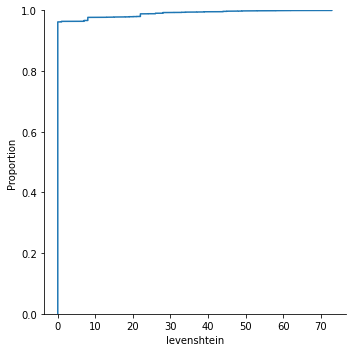

In [29]:
#График распределения расстояния Левенштейна с накоплением
sns.displot(y_test, x="levenshtein", kind="ecdf")

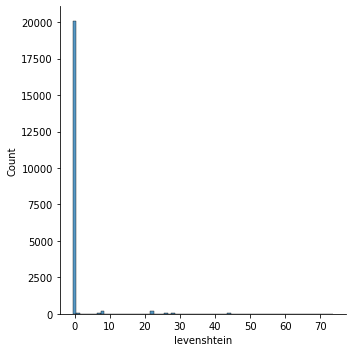

In [30]:
#Гистограмма распределения расстояния Левенштейна
g = sns.displot(y_test, x="levenshtein", discrete=True)


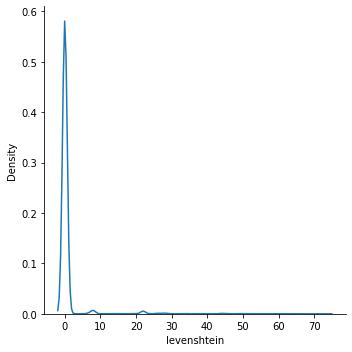

In [31]:
#График плотности распределения расстояния Левенштейна
g = sns.displot(y_test, x="levenshtein", kind = 'kde')

In [32]:
print(y_test["levenshtein"].mean(),y_test["levenshtein"].median())

0.7761859127934835 0.0


In [33]:
data = pd.read_csv("Data.csv", sep=',')
#удаляем неразделяемые строчки (85)
data['failed'] = data['dept_code'].str.contains(';', regex=True)
data = data[data['failed'] == False]

#удаляем наблюдения до 2001 года (ошибки, например, дата заполнения вместо даты рождения)
data['index'] = range(1, len(data) + 1)
data = data[['index', 'dept_code', 'issue_date', 'issuer_eng' ]]
data['issue_date']= pd.to_datetime(data['issue_date'])
data = data[data['issue_date'].dt.strftime('%Y') >= '2001']

# Заменяем дату на количество дней от минимальной в датасете
data['issue_date']= pd.to_datetime(data['issue_date'])
fromDate = min(data['issue_date'])
data['timedelta'] = (data['issue_date'] - fromDate).dt.days.astype(int)
data.drop('issue_date', axis = 1, inplace = True)

#Делим на тестовую и обучающую
x_data_raw = data[['dept_code', 'timedelta']]
y_data_raw = data[['issuer_eng']]
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(x_data_raw, y_data_raw, test_size=0.2, random_state=42)

y_test_raw['knn_predict_1'] = neigh_1.predict(x_test_raw)
neigh_1.score(x_test_raw, y_test_raw['issuer_eng'])

0.598895292987512

In [34]:
#Рассчитываем расстояние Левенштейна между реальными и предсказанными значениями
y_test_raw['levenshtein'] = 0
for ind in y_test_raw.index: 
     y_test_raw['levenshtein'][ind] = Leven.distance(y_test_raw['issuer_eng'][ind], y_test_raw['knn_predict_1'][ind])

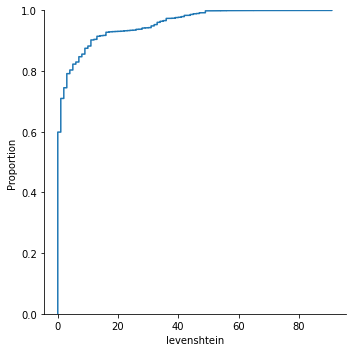

In [35]:
sns.displot(y_test_raw, x="levenshtein", kind="ecdf")

In [36]:
print(y_test_raw["levenshtein"].mean(),y_test_raw["levenshtein"].median())

4.112007684918348 0.0
